# Teoria

## Uczenie Temporal Difference
Metoda **model-free** oznacza, że agent uczy się jedynie poprzez doświadczenie, nie ma on dostępu do macierzy przejść MDP.
Metody Monte Carlo wymagają ukończenia całego epizodu (dopiero wtedy znana jest wartość $G_t$) zanim będzie można zaktualizować wartość $V(S_t)$.
Metody Temporal Difference natomiast mogą dokonać aktualizacji już po jednym kroku czasu

Najprostsza metoda TD dokonuje następującej aktualizacji:
$V(S_t) \leftarrow V(S_t)+\alpha[R_{r+1}+\gamma V(S_{t+1})-V(S_t)]$

Dzieje się to natychmiast po tranzycji do stanu $S_{t+1}$ oraz po otrzymaniu nagrody $R_{t+1}$.
Inaczej mówiąc, metoda ta aktualizuje wartość funkcji $V$ o mały krok $\alpha$ w kierunku celu (*TD target*), który jest w tym przypadku następujący $R_{r+1}+\gamma V(S_{t+1})$ ($G_t$ w przypadku MC). Taka metoda TD nazywana jest $TD(0)$.

Zauważmy, że wartość w nawiasach kwadratowych metody TD(0) jest pewnego rodzaju *błędem* (*TD error*), który mierzy różnicę pomiędzy estymowaną wartością $S_t$ oraz lepszą, nową estymacją $R_{r+1}+\gamma V(S_{t+1})$. Wiele algorytmów uczenia ze wzmocnieniem opartych jest na tej idei.

![](img/td0-backup.png)
Powyżej widzimy diagram dla metody TD(0). Wartość estymowana dla górnego stanu jest aktualizowana na podstawie jednej tranzycji do następnego stanu.

#### Zalety

- Nie wymagają modelu środowiska
- Może je zaimplementować jako algorytm *online*, w pełni inkrementowalnym stylu.

### SARSA
SARSA jest algorytmem **on-policy** i należy do grupy metod sterowania TD.

Jednak, zamiast uczyć się funkcji $V$, uczy się on funkcji $Q$ (funkcja action-value, która może być użyta przez agenta, kiedy nie ma on dostępu do macierzy przejść MDP).

Pierwszym krokiem metody on-policy jest estymacja $q_\pi(s,a)$ dla aktualnej strategii $\pi$ dla wszystkich stanów $s$ i akcji $a$. Możemy tego dokonać, wykorzystując metodę TD opisaną powyżej do uczenia się wartości $v_\pi$.

W poprzedniej sekcji rozważaliśmy tranzycję ze stanu do stanu i uczyliśmy się wartości stanów. Teraz będziemy rozpatrywać tranzycje z par stan-akcja do pary stan-akcja i będziemy się uczyć wartości $q_\pi$.

Aktualizacja wartości $Q$ jest następująca:
$Q(S_t, A_t) \leftarrow Q(S_t, A_t)+\alpha[R_{r+1}+\gamma Q(S_{t+1}, A_{t+1})-Q(S_t, A_t)]$

Uwaga: jest ona dokonywana po każdej tranzycji ze stanu **nieterminalnego**.

![](img/sarsa-backup.png)
Powyżej przedstawiony jest diagram dla algorytmu SARSA.

![](img/sarsa.png)

### Q-learning

Jedną z przełomowych metod uczenia ze wzmocnieniem była metoda off-policy *Q-learning* (również oparta na idei TD).

Formuła aktualizacji wartości $Q$:
$Q(S_t, A_t) \leftarrow Q(S_t, A_t)+\alpha[R_{r+1}+\gamma \max_a Q(S_{t+1}, a)-Q(S_t, A_t)]$

W tym przypadku uczona funkcja $Q$, bezpośrednio przybliża $q_*$, czyli optymalną funkcję action-value. Jest ona niezależna od strategii jaką kieruje się agent w środowisku (stąd off-policy)

![](img/q-learning-backup.png)
Jak widzimy z powyższego diagramu, do aktualizacji wartości $Q$ używamy $\max$ nad wszystkimi możliwymi akcjami (w SARSA używaliśmy tej samej akcji, co agent wykonał w środowisku). To pokazuje, że używamy tak naprawdę dwóch strategii: jednej do zachowania agenta oraz drugiej do aktualizacji wartości $Q$.

![](img/q-learning.png)

# Kod

In [1]:
import gym
import numpy as np

W tym zadaniu wykorzystamy środowisko [Taxi-v3](https://www.gymlibrary.dev/environments/toy_text/taxi/) z biblioteki Gym OpenAI.

Zdefiniujmy strategię $\epsilon-greedy$ do eksploracji środowiska.

In [2]:
def epsilon_greedy(Q, epsilon, n_actions, s, train=False):
    if train or np.random.rand() < epsilon:
        action = np.argmax(Q[s, :])
    else:
        action = np.random.randint(0, n_actions)
    return action

C:\Users\Basia\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Inicjalizacja wartości $Q$.

In [3]:
def init_q_values(s, a, type="ones"):
    if type == "ones":
        return np.ones((s, a))
    elif type == "random":
        return np.random.random((s, a))
    elif type == "zeros":
        return np.zeros((s, a))

Implementacja algorytmu SARSA.

In [4]:
def sarsa(alpha, gamma, epsilon, episodes, max_steps):
    env = gym.make('Taxi-v3')
    n_states, n_actions = env.observation_space.n, env.action_space.n
    Q = init_q_values(n_states, n_actions, type="ones")
    timestep_reward_sarsa = []
    for episode in range(episodes):
        total_reward = 0
        s = env.reset()
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        t = 0
        while t < max_steps:
            t += 1
            s_, reward, done, info = env.step(a)
            total_reward += reward
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            
            Q[s, a] += alpha * ( reward + (gamma * Q[s_, a_] ) - Q[s, a] )
            s, a = s_, a_
            
            if done:
                timestep_reward_sarsa.append(total_reward)
                break
    return timestep_reward_sarsa, Q

Uruchomienie SARSA.

In [5]:
alpha = 0.4
gamma = 0.999
epsilon = 0.9
episodes = 1000
max_steps = 2500
timestep_reward_sarsa, Qsarsa = sarsa(alpha, gamma, epsilon, episodes, max_steps)
print(timestep_reward_sarsa)

[-677, -713, -614, -632, -740, -659, -650, -677, -668, -596, -677, -308, -533, -596, -376, -722, -668, -704, -407, -407, -301, -272, -398, -259, -641, -227, -290, -488, -335, -156, -110, -245, -37, -197, -263, -749, -578, -515, -353, -290, -21, -272, -632, -263, -371, -281, -114, -131, -407, -264, -767, -632, -281, -299, -290, -245, -317, -371, -416, -281, -317, -12, -335, -55, -193, -299, -13, -236, -181, -199, -299, -272, 11, -605, -131, -236, -281, -75, -143, -254, -75, -198, -96, -37, -227, -290, -165, -184, -254, -245, -256, -317, -245, -135, -88, -272, 5, -308, -236, -254, -33, -88, -30, -290, -78, -272, -263, -236, -389, -116, -40, -66, -91, -81, -251, 13, -148, -53, -38, -152, -235, -263, -125, -149, -30, -234, 4, -193, -15, -165, -236, -84, -194, -290, -119, -335, -42, -26, -58, -171, -85, -51, -64, -5, -120, -204, -190, -156, -45, -124, -272, -10, -121, -206, -54, -84, -76, -173, -119, -156, -362, -171, -114, 15, -106, -50, 10, -81, -148, -229, -84, -230, -56, -110, -117, -25

Implementacja algorytmu Q-learning.

In [6]:
def qlearning(alpha, gamma, epsilon, episodes, max_steps):
    env = gym.make('Taxi-v3')
    n_states, n_actions = env.observation_space.n, env.action_space.n
    Q = init_q_values(n_states, n_actions, type="ones")
    timestep_reward_qlearning = []
    for episode in range(episodes):
        s = env.reset()
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        t = 0
        total_reward = 0
        while t < max_steps:
            t += 1
            s_, reward, done, info = env.step(a)
            total_reward += reward
            a_ = np.argmax(Q[s_, :])
            
            Q[s, a] += alpha * ( reward + (gamma * Q[s_, a_]) - Q[s, a] )
            s, a = s_, a_

            if done:
                timestep_reward_qlearning.append(total_reward)
                break
    return timestep_reward_qlearning, Q

Uruchomienie Q-learning

In [7]:
alpha = 0.4
gamma = 0.999
epsilon = 0.9
episodes = 1000
max_steps = 2500
timestep_reward_qlearning, Qlearn = qlearning(alpha, gamma, epsilon, episodes, max_steps)
print(timestep_reward_qlearning)

[-740, -776, -767, -740, -740, -560, -560, -650, -758, -776, -668, -515, -520, -200, -524, -650, -524, -344, -461, -428, -126, -740, -542, -596, -722, -506, -614, -453, -236, -200, -200, -254, -290, -200, -200, -153, -143, -848, -54, -884, -236, -794, -416, -208, -200, -200, -117, -344, -488, -200, -200, -200, -250, -200, -32, -200, -182, -160, -159, -63, -200, -200, -200, -64, -200, -123, -200, -200, -3, -99, -118, -48, -200, -82, -200, -200, -29, -200, -57, -84, -200, -112, -152, -96, -6, -17, -200, -209, -106, -49, -92, -138, -326, -128, -141, -113, -62, -154, -61, -30, -27, -253, -126, -114, -88, -158, -3, -200, -147, -103, -150, 0, 0, -112, -200, -151, -429, -93, -21, -117, -41, -24, -107, -134, -55, -39, -83, -8, -200, -19, -200, -70, -70, -141, -90, -90, -158, -128, -59, -91, -196, 10, -134, -23, -96, -12, -77, -61, -32, 6, -63, -232, -53, -121, -75, -46, -48, -293, -11, -63, -57, -10, -397, -124, -45, -41, -148, -195, 11, 10, -539, -179, -58, -352, 10, -46, 11, 9, -318, -119, -

Zad 2

In [8]:
def test_agent(Q, number_of_tests, render):
    env = gym.make('Taxi-v3')
    n_states, n_actions = env.observation_space.n, env.action_space.n
    result = dict.fromkeys(range(number_of_tests))
    for test in range(number_of_tests):
        result[test] = [0,0]
        s = env.reset()
        done = False
        while not done:
            if render:
                env.render()
            a = epsilon_greedy(Q, epsilon, n_actions, s, train=False)
            tmp_s = s
            s, reward, done, info = env.step(a)

            if s == tmp_s and reward < 0:
                result[test][1] += 1
            result[test][0] += reward
    return result

In [9]:
# w pierwszym elemencie tablicy jest wynik a w drugim
# liczba popełnionych niedozwolonych ruchów

# ustawienie zmiennej render na True, spowoduje odpalenie się wizualizacji symulacji.
# ustawienie zmiennej render na False, spowoduje uruchomienie symulacji bez wizualizacji
test_agent(Qsarsa, 100, False)

{0: [-3, 1],
 1: [-6, 2],
 2: [8, 0],
 3: [6, 0],
 4: [-10, 2],
 5: [-1, 2],
 6: [-64, 47],
 7: [-13, 20],
 8: [-10, 18],
 9: [-15, 2],
 10: [5, 0],
 11: [-23, 5],
 12: [2, 0],
 13: [-10, 1],
 14: [8, 1],
 15: [-2, 1],
 16: [11, 1],
 17: [-272, 185],
 18: [-5, 1],
 19: [7, 0],
 20: [-6, 10],
 21: [-1, 1],
 22: [-26, 12],
 23: [6, 0],
 24: [7, 0],
 25: [-5, 1],
 26: [-5, 1],
 27: [-1, 1],
 28: [12, 0],
 29: [7, 0],
 30: [-6, 10],
 31: [7, 0],
 32: [4, 0],
 33: [11, 1],
 34: [8, 0],
 35: [-16, 2],
 36: [-218, 192],
 37: [8, 1],
 38: [9, 0],
 39: [-110, 37],
 40: [-17, 12],
 41: [10, 0],
 42: [12, 0],
 43: [8, 0],
 44: [-48, 52],
 45: [-120, 113],
 46: [1, 0],
 47: [7, 1],
 48: [11, 0],
 49: [12, 0],
 50: [8, 0],
 51: [-30, 27],
 52: [-2, 2],
 53: [8, 0],
 54: [10, 0],
 55: [-64, 42],
 56: [-50, 38],
 57: [-137, 112],
 58: [13, 0],
 59: [1, 1],
 60: [9, 0],
 61: [9, 1],
 62: [7, 1],
 63: [2, 0],
 64: [9, 0],
 65: [-4, 1],
 66: [1, 1],
 67: [4, 0],
 68: [-5, 11],
 69: [-81, 58],
 70: [9, 0

In [10]:
# ustawienie zmiennej render na True, spowoduje odpalenie się wizualizacji symulacji.
# ustawienie zmiennej render na False, spowoduje uruchomienie symulacji bez wizualizacji
test_agent(Qlearn, 100, False)

{0: [-1, 1],
 1: [-20, 4],
 2: [-6, 2],
 3: [-13, 2],
 4: [8, 0],
 5: [-46, 49],
 6: [4, 1],
 7: [8, 1],
 8: [4, 0],
 9: [4, 0],
 10: [5, 0],
 11: [9, 0],
 12: [-5, 2],
 13: [-3, 1],
 14: [-7, 18],
 15: [6, 1],
 16: [4, 0],
 17: [2, 1],
 18: [9, 0],
 19: [11, 0],
 20: [-50, 39],
 21: [4, 0],
 22: [-10, 6],
 23: [-199, 42],
 24: [12, 0],
 25: [11, 0],
 26: [9, 0],
 27: [7, 0],
 28: [6, 0],
 29: [-3, 1],
 30: [9, 0],
 31: [-107, 12],
 32: [9, 0],
 33: [1, 1],
 34: [10, 0],
 35: [-5, 1],
 36: [4, 2],
 37: [6, 0],
 38: [6, 0],
 39: [-5, 2],
 40: [-3, 1],
 41: [-179, 43],
 42: [8, 1],
 43: [-5, 2],
 44: [-3, 2],
 45: [-23, 4],
 46: [0, 1],
 47: [-6, 1],
 48: [10, 0],
 49: [-4, 1],
 50: [7, 1],
 51: [-9, 4],
 52: [7, 0],
 53: [2, 0],
 54: [8, 0],
 55: [8, 0],
 56: [-14, 2],
 57: [-78, 60],
 58: [0, 1],
 59: [5, 0],
 60: [5, 0],
 61: [2, 2],
 62: [11, 0],
 63: [-5, 1],
 64: [3, 0],
 65: [2, 0],
 66: [14, 0],
 67: [-4, 1],
 68: [11, 0],
 69: [4, 1],
 70: [5, 0],
 71: [3, 0],
 72: [-8, 1],
 73:

Czy można wytrenować agenta w ten sposób, aby nie popełnił błędu w żadnym z epizodów? <br>
<br>
Wydaje mi się, że można wytrenować agenta w ten sposób, aby nie popełnił błędu w żadnym z epizodów. Skoro środowisko agenta się nie zmienia, to w końcu nauczy się po n iteracjach obierać optymalne trasy, co zredukuje liczbę błędów do zera.

Zad 3

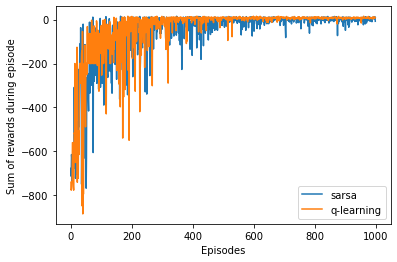

In [11]:
import matplotlib.pyplot as plt
X = list(range(len(timestep_reward_sarsa)))
Y = list(range(len(timestep_reward_qlearning)))

plt.plot(X, timestep_reward_sarsa, label='sarsa')
plt.plot(X, timestep_reward_qlearning, label='q-learning')

plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')

plt.legend()

# Zadanie

1. Uzupełnij puste miejsca w kodzie dla algorytmu SARSA oraz Q-learning.
2. Napisz metodę, która będzie oceniała zachowanie agenta. Pokaż wizualnie, jak zachowuje się agent, używając wyuczonej strategii (użyj `env.render()`). Dodatkowo dokonaj ewaluacji swojego agenta na przestrzeni 100 epizodów - ile razy popełnił błąd (wykonał akcję zabronioną)? Czy można wytrenować agenta w ten sposób, aby nie popełnił błędu w żadnym z epizodów?
3. Pokaż wykres, który wizualizuje proces uczenia się agenta. Innymi słowy, pokaż całkowitą nagrodę, jaką osiągnął agent za każdy epizod uczenia. Przedstaw na jednym wykresie wyniki dla obu algorytmów.

## Materiały

- [RL Course by David Silver - Lecture 5: Model Free Control](https://www.youtube.com/watch?v=0g4j2k_Ggc4&list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-&index=9)
- Sutton, Barto - Chapter 6